# Do stars either side of the rotation gap have different spatial distributions?

In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import scipy.stats as sps

Load Megan Bedell's Kepler - Gaia crossmatched table.

In [4]:
dat = Table.read('kepler_dr2_4arcsec_updated.fits', format='fits')
d = dat.to_pandas()
print(np.shape(d), "Stars observed by both Gaia and Kepler")

(232844, 101) Stars observed by both Gaia and Kepler


Load the McQuillan Catalogue.

In [5]:
M1 = pd.read_csv("Table_1_Periodic.txt")
print(np.shape(M1), "Kepler stars with McQuillan rotation periods")

(34030, 11) Kepler stars with McQuillan rotation periods


Do an inner merge.

In [8]:
df = pd.merge(d, M1, how="inner", on="kepid", suffixes=["_Bedell", "_KIC"])

In [9]:
# Get rid of duplicates.
print(np.shape(df))
df = df.drop_duplicates(subset="kepid")
print(np.shape(df))

(40359, 111)
(33375, 111)


Cut on temperature, log g and parallax signal-to-noise. Plot remaining sample on HR diagram...

Text(0,0.5,'log g')

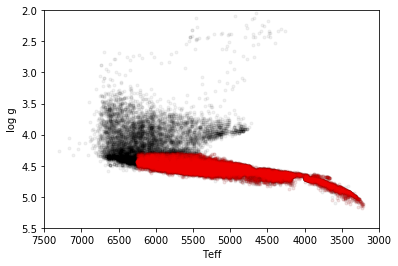

In [14]:
plt.plot(df.teff, df.logg_Bedell, "k.", alpha=.05)
plt.xlim(7500, 3000)
plt.ylim(5.5, 2)

m = 10 < df.parallax_over_error.values  # Signal to noise greater than 10
m &= np.isfinite(df.radial_velocity.values)
#m &= df.radial_velocity.values != 0.
m &= df.teff.values < 6250
m &= 4.3 < df.logg_Bedell.values

d = df.iloc[m]
plt.plot(d.teff, d.logg_Bedell, "r.", alpha=.05)
plt.xlabel("Teff")
plt.ylabel("log g")

And in rotation period - temperature space.

Text(0,0.5,'Rotation period [days]')

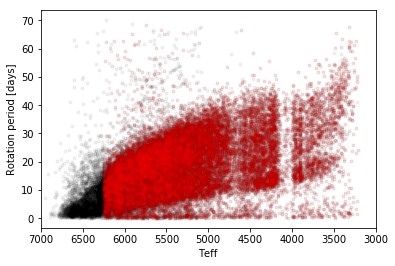

In [15]:
plt.plot(df.teff, df.Prot, "k.", alpha=.05)
plt.plot(d.teff, d.Prot, "r.", alpha=.05)
plt.xlim(7000, 3000)
plt.xlabel("Teff")
plt.ylabel("Rotation period [days]")

Zoom in on the cool stars.

Text(0,0.5,'Rotation period [days]')

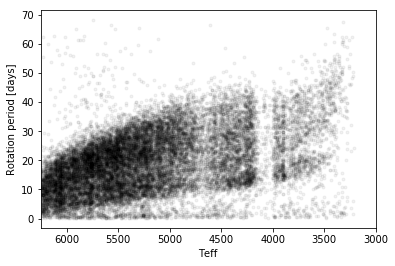

In [16]:
plt.plot(d.teff, d.Prot, "k.", alpha=.05)
plt.xlim(6250, 3000)
plt.xlabel("Teff")
plt.ylabel("Rotation period [days]")

Select cool stars

Text(0,0.5,'Rotation period [days]')

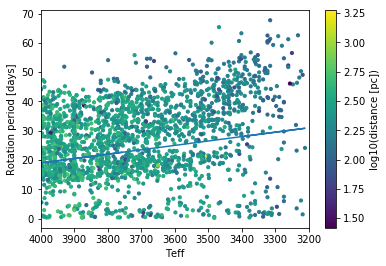

In [18]:
m = 3000 < d.teff.values
m &= d.teff.values < 4000
plt.scatter(d.teff.values[m], d.Prot[m], c=np.log10(d.r_est[m]), s=10)
plt.plot(d.teff.values[m], -.015 * d.teff.values[m] + 79)
plt.colorbar(label="log10(distance [pc])")
plt.xlim(4000, 3200)
plt.xlabel("Teff")
plt.ylabel("Rotation period [days]")

Just take the stars below the rotation gap and exclude the ultra-fast rotators (UFRs).

(4000, 3200)

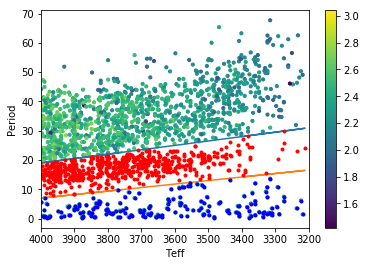

In [20]:
m2 = d.Prot[m] < -.015 * d.teff.values[m] + 79
m2 &= d.Prot[m] > -.012 * d.teff.values[m] + 55
m3 = d.Prot[m] < -.012 * d.teff.values[m] + 55
plt.scatter(d.teff.values[m][~m2], d.Prot[m][~m2], c=np.log10(d.r_est[m][~m2]), s=10)
plt.plot(d.teff.values[m], -.015 * d.teff.values[m] + 79)
plt.plot(d.teff.values[m], -.012 * d.teff.values[m] + 55)
plt.plot(d.teff.values[m][m2], d.Prot[m][m2], "r.")
plt.plot(d.teff.values[m][m3], d.Prot[m][m3], "b.")
plt.xlabel("Teff")
plt.ylabel("Period")
plt.colorbar()
plt.xlim(4000, 3200)

(-0.07376800422953007, 0.03745070841038839)


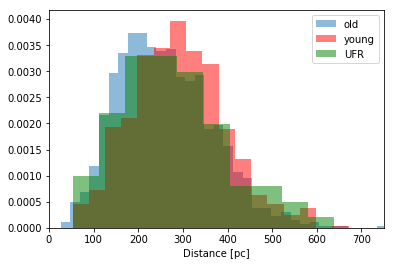

In [23]:
m2 = d.Prot[m] < -.015 * d.teff.values[m] + 79
plt.hist(d.r_est.values[m][~m2], 50, normed=True, alpha=.5, label="old");
plt.hist(d.r_est.values[m][m2], 50, normed=True, alpha=.5, color="r", label="young");
plt.hist(d.r_est.values[m][m3], 10, normed=True, alpha=.5, color="g", label="UFR");
plt.legend()
plt.xlabel("Distance [pc]")
plt.xlim(0, 750)

x = np.random.choice(d.r_est.values[m][~m2], len(d.r_est.values[m][m2]))
print(sps.pearsonr(x, d.r_est.values[m][m2]))

Red and blue look pretty different, but is that just because we can measure rotation periods out to larger distances for rapidly rotating stars?. Plot the 'old' and 'young' population as a function of cylindrical galactic coordinates. If the two populations are truly spatial separated in 3d, not just in radial distance, this should be visible when coverting to a non-heliocentric coordinate system.

In [24]:
from actions import action
from tqdm import tqdm

actions = np.zeros((len(d.kepid.values[m]), 9))
for i in tqdm(range(len(d.kepid.values[m]))):
    actions[i, :] = action(d.ra.values[i], d.dec.values[i], d.r_est.values[i]*1e-3, 
                           d.pmra.values[i], d.pmdec.values[i], d.radial_velocity.values[i])

  0%|          | 6/2021 [00:00<00:36, 55.73it/s]

100%|██████████| 2021/2021 [00:31<00:00, 64.55it/s]


Functions for plotting the distributions of fast and slow rotators in cylindrical coordinates. I don't find e

In [25]:
labels = ["$R [kpc]$", "$\phi [rad]$", "z_kpc", "vR_kms", "vT_kms", "vz_kms", "jR", "lz", "jz"]

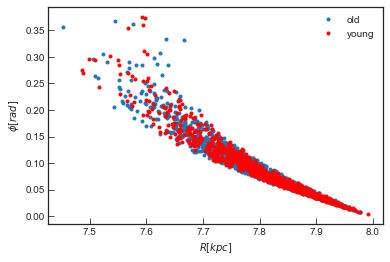

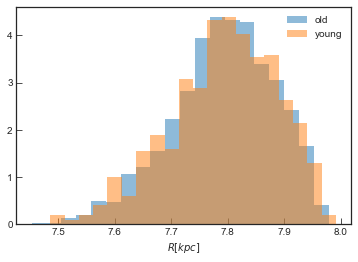

old median =  7.7975221353905315 young median =  7.800068393434255
old variance =  0.008182933710779123 young variance =  0.008847356321865405
(0.05695061546795079, 0.1083722058260255)


In [26]:
def make_ndplots(actions, m2, labels, i, nbins, logx=False, logy=False):
    
    x_old = actions[:, i][~m2]
    x_young = actions[:, i][m2]
    y_old = actions[:, i+1][~m2]
    y_young = actions[:, i+1][m2]
    
    if logx:
        x_old = np.log10(actions[:, i][~m2])
        x_young = np.log10(actions[:, i][m2])
        
    if logy:
        y_old = np.log10(actions[:, i+1][~m2])
        y_young = np.log10(actions[:, i+1][m2])

    plt.plot(x_old, y_old, ".", label="old")
    plt.plot(x_young, y_young, "r.", label="young")
    plt.legend()
    plt.xlabel(labels[i])
    plt.ylabel(labels[i+1])
    plt.show()

    plt.hist(x_old, nbins, label="old", normed=True, alpha=.5)
    plt.hist(x_young, nbins, label="young", normed=True, alpha=.5)
    plt.legend()
    plt.xlabel(labels[i])
    plt.show()
    
    print("old median = ", np.median(x_old), "young median = ", np.median(x_young))
    print("old variance = ", np.var(x_old), "young variance = ", np.var(x_young))
    
    old = np.random.choice(x_old, len(x_young))
    print(sps.pearsonr(old, x_young))
    
make_ndplots(actions, m2, labels, 0, 20)

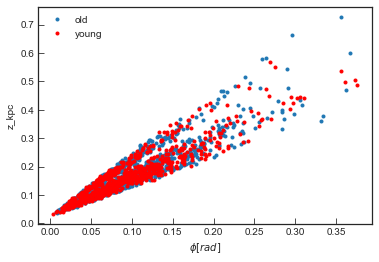

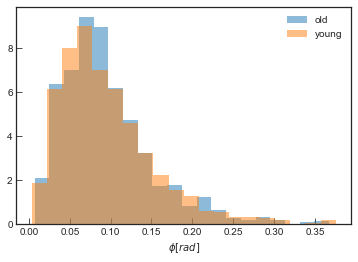

old median =  0.08466688372745489 young median =  0.0817941704939674
old variance =  0.0030698414758981514 young variance =  0.0034257414351606588
(-0.04662903465037462, 0.1887740449642864)


In [27]:
make_ndplots(actions, m2, labels, 1, 20)

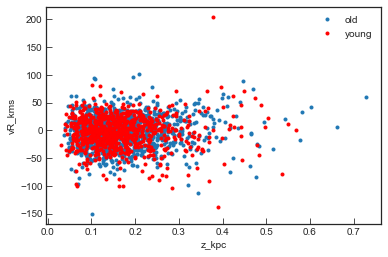

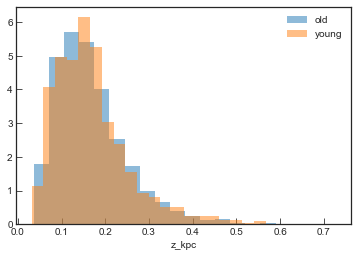

old median =  0.15209460813194772 young median =  0.15419756257295036
old variance =  0.007399866285803674 young variance =  0.007437057769719341
(0.008712770329713869, 0.8061189651158365)


In [28]:
make_ndplots(actions, m2, labels, 2, 20)

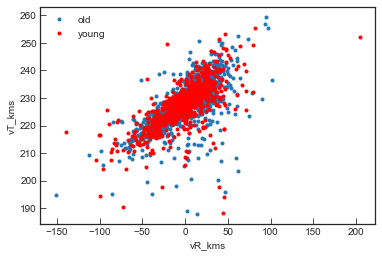

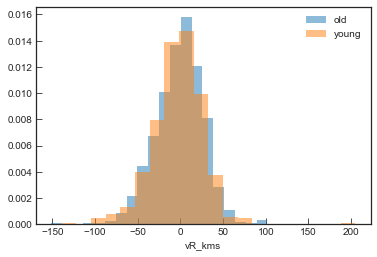

old median =  1.1851885313574924 young median =  -0.9978033799710566
old variance =  773.5198251046328 young variance =  886.1854290781816
(-0.04566254501819756, 0.19811321191375006)


In [29]:
make_ndplots(actions, m2, labels, 3, 20)

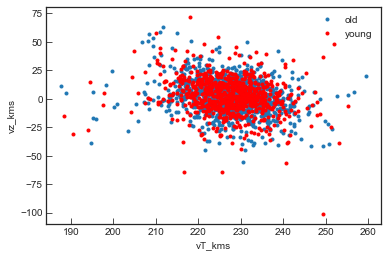

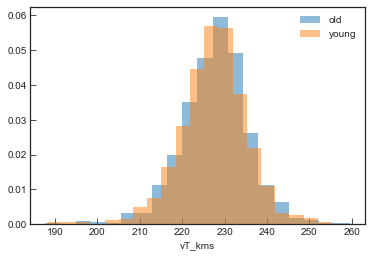

old median =  228.2643529448988 young median =  227.58583331097032
old variance =  64.46705307019785 young variance =  65.27400991362231
(0.002640297846890059, 0.9407119724036873)


In [30]:
make_ndplots(actions, m2, labels, 4, 20)

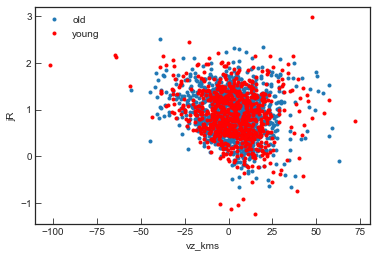

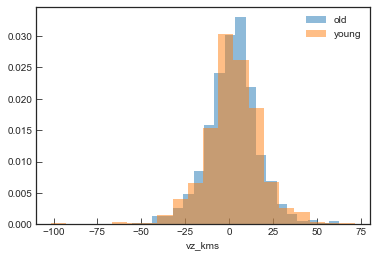

old median =  2.6891335184624845 young median =  2.3310934160732764
old variance =  215.98689922612374 young variance =  253.39333780839547
(-0.05823435908308223, 0.1006304271462556)


In [31]:
make_ndplots(actions, m2, labels, 5, 20, logy=True)

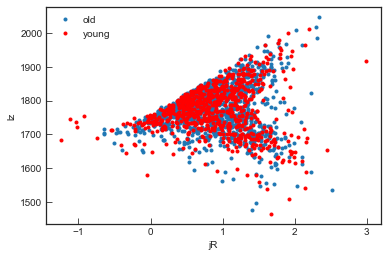

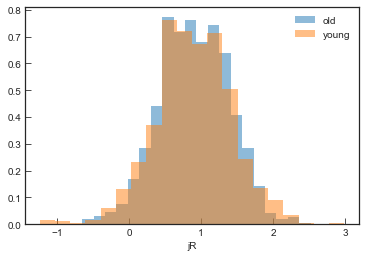

old median =  0.8863863072776369 young median =  0.889551373822855
old variance =  0.23539082623657995 young variance =  0.287135855810906
(0.040763454466982194, 0.2506596041282118)


In [32]:
make_ndplots(actions, m2, labels, 6, 20, logx=True)

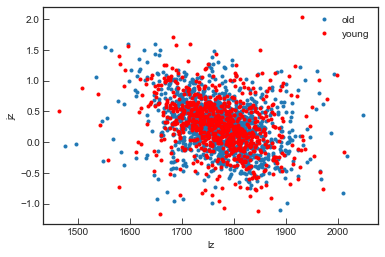

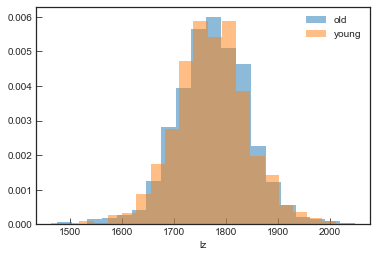

old median =  1774.9835826906342 young median =  1771.1736535742393
old variance =  4827.240322708267 young variance =  4990.570241250891
(0.021990203193580284, 0.5355739081984019)


In [33]:
make_ndplots(actions, m2, labels, 7, 20, logy=True)